# Main Figures
**Code for reproducing main figures in the manuscript**

For any question please contact the first author Yang Luo: yangluo@broadinstitute.org

## load up settings

In [1]:
#Load libraries
library(ggplot2)
library(reticulate)
library(repr)
library(patchwork)
library(tidyr)
library(plyr) 
library(dplyr)
library(data.table)
library(scales)
library(ggthemes)
library(ggsci)
library(plotrix)
library(RColorBrewer)
library(ggrepel)
library(gridExtra)
library(cowplot)
library(grid)
library(corrplot)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘plotrix’


The following object is masked from ‘package:scales’:

    rescale



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘cowplot’


The following object is m

In [2]:
# set global plotting parameters
theme_set(theme_bw() + theme(text = element_text(size=20, family = "sans")))

options(repr.plot.width = 10, repr.plot.height = 7)

pop_colors <- c("#938dd2","#E69F00" ,"#56B4E9","#D55E00","#009E73")
pop_labels <- c("Admixed African","East Asian","European","Latino", "South Asian")

#Calc color palette (discrete)
gene_colors <- c("A"="#004586", "B" = "#ff420e", "C"="#ffd320", 
                 "DQA1" = "#579d1c", "DQB1" = "#7e0021", "DRB1" = "#83caff","DPA1" = "#314004", "DPB1" = "#aecf00"  )

panel_colors <- c("darkorchid4", "plum","darkorange")
panel_names <- c("Multi-ethnic WGS (5,225)",
                                      "Multi-ethnic WGS (21,546)","T1DGC (5,225)")

## Population Diversity (Figure 1)

### PCA analysis (Figure 1a)

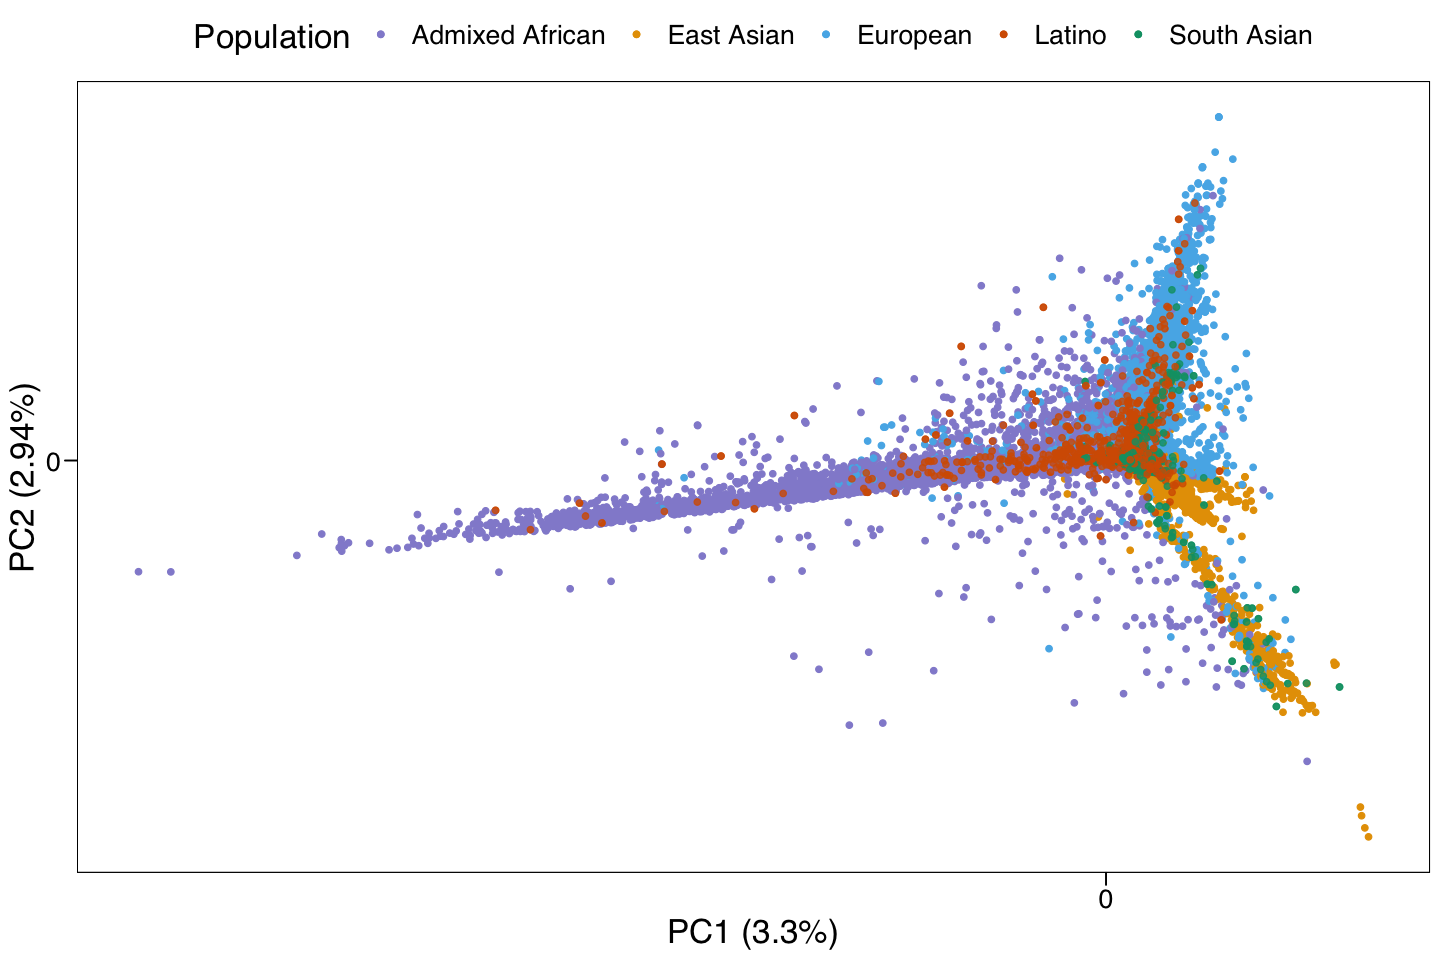

In [3]:
options(repr.plot.width = 12, repr.plot.height = 8)

pc <- read.table("../data//all_ibd_pcs.txt.gz",h=T,stringsAsFactors = F)

# for better visualization
pc$label <- "a"
pc[pc$ancestry=="LAT" | pc$ancestry=="SAS",]$label <- "focus" 

varexp <- c(0.033,0.0294)*100


weightedpc.plot <- ggplot(pc,aes(x=V1,y=V2,colour=ancestry, alpha = label )) + geom_point() +
    geom_point(data=subset(pc,label == "focus"), aes(x=V1,y = V2, color = ancestry)) +
    scale_alpha_manual(guide="none",values=list(a=1,focus=.8))


weightedpc.plot <- weightedpc.plot + scale_colour_manual(values=pop_colors,
                                                         name="Population",
                                                        labels=pop_labels)
weightedpc.plot <- weightedpc.plot + theme_base() 

weightedpc.plot <- weightedpc.plot + 
  xlab(paste("PC1 (",round(varexp[1],2),"%)",sep=""))+ylab(paste("PC2 (",round(varexp[2],2),"%)",sep=""))


weightedpc.plot  <- weightedpc.plot + theme(legend.position="top",
                        plot.background=element_blank(),
                        text = element_text(size = 20, family = "sans"))
weightedpc.plot  <- weightedpc.plot  + scale_x_continuous(breaks = 0) + scale_y_continuous(breaks = 0)

weightedpc.plot
ggsave(filename = "../figs/Fig1a-PCA.png",height=8,width=10)


### B frequencies by continental groups (Figure 1b)

In [5]:
#' Plots a series of barplots and connects them 
#' Modified from https://stackoverflow.com/questions/22560850/barplot-with-connected-series
#' 
#' @param dat NxM matrix with N rows as features and M columns as samples
#' @param color Vector of N colors
#' @param space Space between barplots
#' @param alpha Alpha for area connecting barplots
#' 
#' @examples
#' dat <- matrix(rnorm(100),10,10)
#' dat <- abs(matrix(rnorm(100),10,10)) 
#' connectedBarplot(dat, color=rainbow(nrow(dat)))
#'

connectedBarplot <- function(dat, color=rainbow(nrow(dat)), space=.21, alpha=0.5, dist=.5, ...) {  
  b <- barplot(dat, col=color, space = space, ...)                     
  H <- apply(dat, 2L, cumsum)
  H <- H - dat / 2
  text(rep(b, each = nrow(H)), H, labels = rownames(dat))
  
  for (i in seq_len(ncol(dat) - 1)) {     
    lines(c(b[i]+dist, b[i+1]-dist), c(0, 0)) ## bottom line       
    
    for (j in seq_len(nrow(dat))) {     
      if (j == 1) {                   
        lines(c(b[i]+dist, b[i+1]-dist), c(dat[j,i], dat[j,i+1]))                       
        polygon(c(b[i]+dist, b[i]+dist, b[i+1]-dist, b[i+1]-dist),                        
                c(0, dat[j,i], dat[j,i+1], 0),               
                col=adjustcolor(color[j], alpha.f=alpha))    
      }      
      if (j == 2) {                   
        lines(c(b[i]+dist, b[i+1]-dist), c(colSums(dat[1:j,])[i], colSums(dat[1:j,])[i+1]))                      
        polygon(c(b[i]+dist, b[i]+dist, b[i+1]-dist, b[i+1]-dist),                        
                c(dat[1,i], colSums(dat[1:j,])[i], colSums(dat[1:j,])[i+1], dat[1,i+1]),                       
                col=adjustcolor(color[j], alpha.f=alpha))    
      }      
      if (j > 2) {                    
        lines(c(b[i]+dist, b[i+1]-dist), c(colSums(dat[1:j,])[i], colSums(dat[1:j,])[i+1]))                      
        polygon(c(b[i]+dist, b[i]+dist, b[i+1]-dist, b[i+1]-dist),                        
                c(colSums(dat[1:(j-1),])[i], colSums(dat[1:j,])[i], colSums(dat[1:j,])[i+1], colSums(dat[1:(j-1),])[i+1]),              
                col=adjustcolor(color[j], alpha.f=alpha))    
      #    legend("top", inset=c(0,0), rev(rownames(dat)), fill = rev(color), ncol = 1, cex = 2)
      }      
    }          
  } 
    
}   

In [4]:
Ggroup<-read.table("../data/Ggroups.txt.gz",h=T,sep=" ")
Ggroup[Ggroup$ethnicity == "missing", ]$ethnicity <- "AFR"
Ggroup$ethnicity <- factor(Ggroup$ethnicity)
#creat frequency table

create_table<-function(dat=Ggroup,genes=c("A","B","C","DQA1","DQB1","DRB1","DPA1","DPB1")){
    out<-NULL
    for (gene in genes){
        x<-subset(dat,select=c(paste(gene,"1",sep="")))%>% unlist() %>% as.vector()
        y<-subset(dat,select=c(paste(gene,"2",sep="")))%>% unlist() %>% as.vector()
        df<-c(x,y)
        frq<-as.data.frame(table(df)/(nrow(dat)*2))
        frq$Gene <- gene
        out<-rbind(out,frq)
    }
    names(out)[1]<-"Var1"
    return(out)
}


In [6]:
all <- ddply(Ggroup[,1:16], .(Ggroup$ethnicity), create_table)

names(all)[1]<-"superpop"

#define top most frequent alleles
df2<-all %>% group_by(Gene,superpop) %>% top_n(2, Freq) %>% arrange(Gene,superpop,desc(Freq))
others<-setDT(all[all$Var1 %in% df2$Var1,])[, .(Var1="others",Freq=1-sum(Freq)), by= .(Gene, superpop)] 


df3<-rbind(all[all$Var1 %in% df2$Var1,],others)
count<-aggregate(df3$Var1, list(df3$Gene),unique)


In [10]:
ancs <- c('AA','EUR','LAT','EAS','SAS')
df3[df3$superpop=="AFR",]$superpop <- "AA"
alleles <- unique(df3[df3$Gene=="B",2])

plt <- matrix(0L,ncol=length(ancs),nrow=nrow(alleles))
n <- 1
for (anc in ancs){
    y <- df3[df3$Gene=="B" & df3$superpop==anc,]
    plt[,n] <- y[match(alleles$Var1, y$Var1),]$Freq*100
    n <- n + 1
}

plt[is.na(plt)] <- 0

plt <- cbind(plt,rowMeans(plt))
colnames(plt) <- c(ancs,"ALL")
rownames(plt) <- alleles$Var1

df.plt <- plt[order(plt[,6],decreasing = T),-6]
head(df.plt)
options(repr.plot.width = 15, repr.plot.height = 8)
pdf("../figs/Fig1b-Bfreq.pdf",width=11,height=7)
op <- par(family = "sans")

layout(rbind(1,2), height=c(2,7))  # put legend on bottom 1/8th of the chart
# setup for no margins on the legend
par(mar=c(3, 5, 0, 0))
# c(bottom, left, top, right)
plot.new()
legend("center", rev(rownames(df.plt)),bty ="n",ncol=5,x.intersp=0.25,text.width=.17,
       fill = rev(c("grey",brewer.pal(nrow(plt)-1,"Paired"))), cex = 1.5)

# setup for no margins on the legend
#par(mar=c(0, 0, 0, 0))
# c(bottom, left, top, right)
#plot.new()
connectedBarplot(df.plt , space=0.3,color=c("grey",brewer.pal(nrow(plt)-1,"Paired")),alpha=.2,ylab="Allele frequency",
                 cex.names=2,cex.lab=1.8,cex.axis=1.5)


dev.off()


,AA,EUR,LAT,EAS,SAS
others,69.0024207,60.5624816,80.3571429,62.3006283,57.361963
B*07:02:01G,6.9754109,13.1638363,6.1974790,3.5524408,3.987730
B*35:01:01G,6.4403109,5.5610091,5.6197479,5.3165781,3.987730
B*08:01:01G,3.7138489,10.8667910,3.0462185,0.1933301,4.907975
B*40:01:01G,1.3058988,5.2616079,1.6281513,8.8690188,1.635992
B*52:01:01G,0.1974774,0.8098557,0.7878151,6.5490575,9.304703


pdf 
  2

### DQA1 frequencies by continetal groups (Figure 1c)

In [12]:
alleles <- unique(df3[df3$Gene=="DQA1",2])
df3[df3$Var1 == "DQA1*02:01",]$Var1 <- "DQA1*02:01:01G"

plt <- matrix(0L,ncol=length(ancs),nrow=nrow(alleles))
n <- 1
for (anc in ancs){
    y <- df3[df3$Gene=="DQA1" & df3$superpop==anc,]
    plt[,n] <- y[match(alleles$Var1, y$Var1),]$Freq*100
    n <- n + 1
}

plt[is.na(plt)] <- 0

plt <- cbind(plt,rowMeans(plt))
colnames(plt) <- c(ancs,"ALL")
rownames(plt) <- alleles$Var1

df.plt <- plt[order(plt[,6],decreasing = T),-6]
df.plt
options(repr.plot.width = 15, repr.plot.height = 8)
pdf("../figs/Fig1c-DQA1freq.pdf",width=11,height=7)
op <- par(family = "sans")

layout(rbind(1,2), height=c(2,7))  # put legend on bottom 1/8th of the chart
# setup for no margins on the legend
par(mar=c(3, 5, 0, 0))
# c(bottom, left, top, right)
plot.new()
legend("center", rev(rownames(df.plt)),bty ="n",ncol=5,x.intersp=0.25,text.width=.17,
       fill = rev(c("grey",brewer.pal(nrow(plt)-1,"Paired"))), cex = 1.5)

# setup for no margins on the legend
#par(mar=c(0, 0, 0, 0))
# c(bottom, left, top, right)
#plot.new()
connectedBarplot(df.plt , space=0.3,color=c("grey",brewer.pal(nrow(plt)-1,"Paired")),alpha=.2,ylab="Allele frequency",
                 cex.names=2,cex.lab=1.8,cex.axis=1.5)


dev.off()
#connectedBarplot(plt, space=0.3, color=c("grey",rep(pop_colors,2)),alpha=.2,ylab="Allele frequency")
                 #cex.names=1.5,cex.lab=1.5,cex.axis=1.5)


,AA,EUR,LAT,EAS,SAS
others,27.799720,17.870816,24.107143,21.29048,23.00613
DQA1*03:01:01G,11.033253,16.879356,25.315126,34.70275,10.02045
DQA1*05:01:01G,20.321060,26.234416,24.632353,11.64814,13.08793
DQA1*01:02:01G,29.417760,19.495435,11.239496,15.53891,11.55419
DQA1*01:03:01G,4.580201,7.146363,4.411765,13.84727,22.59714
DQA1*02:01:01G,6.848006,12.373613,10.294118,2.97245,19.73415


pdf 
  2

## epsilon (Figure 2a)

In [14]:
M <- 0
for (pop in c("EUR","SAS","EAS","LAT","AA")){
  M1 <- as.matrix(read.table(paste("../data/",pop,"_eps.txt",sep=""),h=T,stringsAsFactors = F))
  M <- M + M1
}

#M/5
rownames(M)<-colnames(M)<-c("A","C","B","DRB1","DQA1","DQB1","DPA1","DPB1")


cols <- colorRampPalette(rev(pal_locuszoom(palette = c("default"))(4)))

pdf("../figs/all_eps.pdf",height=6,width=6)
  
#diag(M) = 1
corrplot.mixed(M/5, lower.col=cols(50),upper = "circle", 
                 tl.col = "black", upper.col = cols(50), cl.lim=c(0,.35),tl.cex=1.3)

dev.off()

pdf 
  2

In [ ]:
### Figure 2b is generated using disentangler

http://kumasakanatsuhiko.jp/projects/disentangler/

with data
